In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.nn import functional as F
from IPython import display
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)

In [3]:
tree = uproot.open("/home2/chenxu/work/corsika/50GeV_1TeV_zen0.gamma.root:tCorsika")
tree.keys()

['evth',
 'evth/TObject',
 'evth/TObject/fUniqueID',
 'evth/TObject/fBits',
 'evth/fLia[312]',
 'evte',
 'evte/TObject',
 'evte/TObject/fUniqueID',
 'evte/TObject/fBits',
 'evte/fLia[312]',
 'secParticles',
 'secParticles/secParticles.fUniqueID',
 'secParticles/secParticles.fBits',
 'secParticles/secParticles.fLia[8]']

In [4]:
primary = tree['evth'].array()
print(len(primary))
primary[0]

100000


<Record {TObject: {...}, 'fLia[312]': ..., ...} type='{TObject: {fUniqueID:...'>

In [5]:
pri=primary["fLia[312]"]

In [6]:
pri = np.array(pri)

In [7]:
prie = pri[:,3]

In [8]:
secs = tree['secParticles/secParticles.fLia[8]'].array()

In [9]:
print('events:',len(secs))
print('secs @ event[1]:',len(secs[0]))
print('sec[1] @ event[1]:',len(secs[1][1]))

events: 100000
secs @ event[1]: 433
sec[1] @ event[1]: 8


In [13]:
len(secs[1])

105

In [14]:
secs[0]

<Array [[1e+03, 0.00064, ..., 4.56e-41], ..., [...]] type='433 * 8 * float32'>

In [10]:
sectype = list()
for i in range(100000):
    sectype.append(np.floor(np.array(secs[i])[:,0]/1000).astype(int))
sectype = np.concatenate(sectype)

In [11]:
sectype = list(set(sectype))

In [17]:
secstype = [[1, 2, 3, 7], [5, 6], [8, 9, 13, 14, 15, 25]]

[1, 2, 3, 7]
6.0


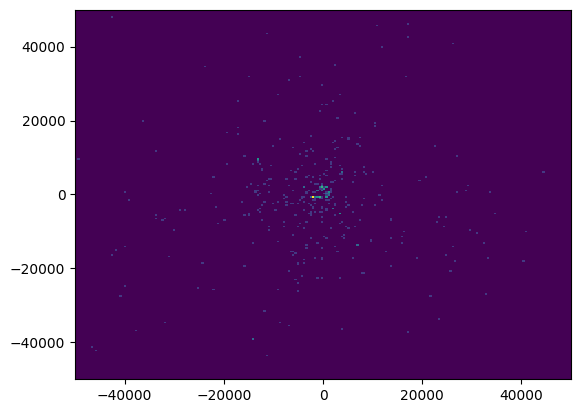

[5, 6]
0.0


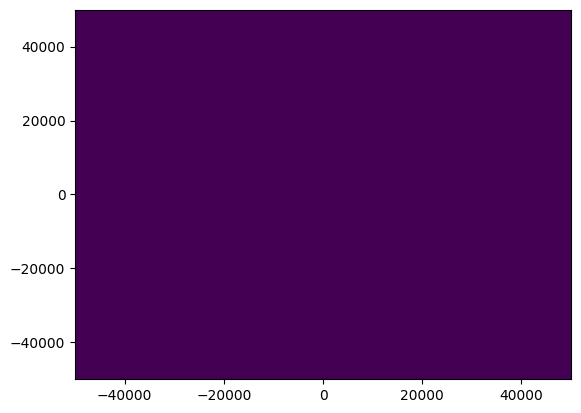

[8, 9, 13, 14, 15, 25]
0.0


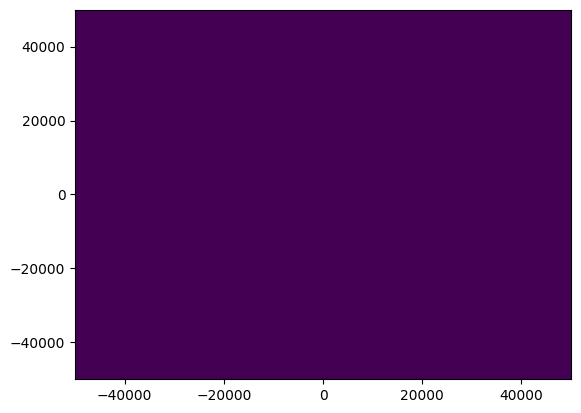

In [18]:
sec = np.array(secs[0])
sec=sec[:,:-1]
xbins = np.linspace(-500*100,500*100,225)
ybins = np.linspace(-500*100,500*100,225)
for i in secstype:
    print(i)
    H,_,_ = np.histogram2d(sec[:,4][np.isin((sec[:,0]/1000).astype(int),i)],sec[:,5][np.isin((sec[:,0]/1000).astype(int),i)],bins=(xbins,ybins))
    H=H.T
    print(np.max(H))
    X,Y = np.meshgrid(xbins,ybins)
    plt.pcolormesh(X, Y, H)
    plt.show()

In [16]:
gamma_log10energy = np.log10(prie).astype(np.float32)

In [19]:
gamma_Matrix = np.zeros(
    [len(gamma_log10energy), len(secstype), 224, 224], dtype=np.float32
)

In [20]:
gamma_Matrix[0,0,0,0]=1

In [21]:
np.where(gamma_Matrix!=0)

(array([0]), array([0]), array([0]), array([0]))

In [16]:
class MCDataset_log10energy(Dataset):
    def __init__(self, prie, secs):
        self.prie = prie
        self.secs = secs
        self.xbins = np.linspace(-500 * 100, 500 * 100, 225)
        self.ybins = np.linspace(-500 * 100, 500 * 100, 225)
        self.secstype = [[1, 2, 3, 7], [5, 6], [8, 9, 13, 14, 15, 25]]
        self.log10energy = np.log10(self.prie).astype(np.float32)
        self.Matrix = np.zeros(
            [len(self.prie), len(self.secstype), 224, 224], dtype=np.float32
        )
        for i in tqdm(range(len(self.prie))):
            sec = np.array(secs[i]).reshape(-1, 8)
            for j, sectype in enumerate(self.secstype):
                self.Matrix[i, j], _, _ = np.histogram2d(
                    sec[:, 4][np.isin((sec[:, 0] / 1000).astype(int), sectype)],
                    sec[:, 5][np.isin((sec[:, 0] / 1000).astype(int), sectype)],
                    bins=(self.xbins, self.ybins),
                )

    def __len__(self):
        return len(self.prie)

    def __getitem__(self, index):
        index = [index]
        return (
            torch.from_numpy(self.Matrix[index]),
            torch.from_numpy(self.log10energy[index]),
        )

In [17]:
train_index, test_index = train_test_split(
    range(len(prie)), random_state=42, test_size=0.3
)

In [18]:
MCdataset_gamma_train = MCDataset_log10energy(prie[train_index], secs[train_index])
MCdataset_gamma_test = MCDataset_log10energy(prie[test_index], secs[test_index])

  0%|          | 0/70000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

In [19]:
np.save("./gamma_train_Matrix.npy",MCdataset_gamma_train.Matrix)
np.save("./gamma_test_Matrix.npy",MCdataset_gamma_test.Matrix)

In [20]:
np.save("./gamma_train_prie.npy",MCdataset_gamma_train.log10energy)
np.save("./gamma_test_prie.npy",MCdataset_gamma_test.log10energy)

In [18]:
MCdataset_gamma_train_dataloader = DataLoader(MCdataset_gamma_train,batch_size=256,shuffle=True)
MCdataset_gamma_test_dataloader = DataLoader(MCdataset_gamma_test,batch_size=256,shuffle=True)

In [19]:
for i in MCdataset_gamma_train_dataloader:
    print(i[0].shape)
    break

torch.Size([256, 1, 5, 224, 224])


In [20]:
class Residual(nn.Module):
    def __init__(self, input_channels, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(
            input_channels, num_channels, kernel_size=3, padding=1, stride=strides
        )
        self.conv2 = nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(
                input_channels, num_channels, kernel_size=1, stride=strides
            )
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

In [21]:
b1 = nn.Sequential(
    nn.Conv2d(5, 64, kernel_size=7, stride=2, padding=3),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
)

In [22]:
def resnet_block(input_channels, num_channels, num_residuals, first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(
                Residual(input_channels, num_channels, use_1x1conv=True, strides=2)
            )
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

In [23]:
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

In [24]:
net = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool2d((1,1)),
                    nn.Flatten(), nn.Linear(512, 1))

In [25]:
net

Sequential(
  (0): Sequential(
    (0): Conv2d(5, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Residual(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Residual(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-

In [26]:
X = torch.rand(size=(1, 5, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 128, 28, 28])
Sequential output shape:	 torch.Size([1, 256, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 512, 1, 1])
Flatten output shape:	 torch.Size([1, 512])
Linear output shape:	 torch.Size([1, 1])


In [27]:
train_error = list()
test_error = list()


def train(net, num_epochs, lr, device):
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)

    net = net.apply(init_weights).to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = nn.MSELoss()
    pred_list = list()
    orgin_list = list()
    for epoch in tqdm(range(num_epochs)):
        net.train()
        for X, y in tqdm(MCdataset_gamma_train_dataloader, leave=False):
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            pred_list.append(y_hat)
            orgin_list.append(y)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
        del(X)
        del(y)
        pred_list = torch.cat(pred_list)
        orgin_list = torch.cat(orgin_list)
        root_mean_squared_error = np.sqrt(loss(pred_list, orgin_list).item())
        train_error.append(root_mean_squared_error)
        print(
            f"epoch:{epoch} train root mean squared error:{root_mean_squared_error:.4f}"
        )
        test_root_mean_squared_error = test(net)
        print(
            f"epoch:{epoch} test root mean squared error:{test_root_mean_squared_error:.4f}"
        )
        test_error.append(test_root_mean_squared_error)


def test(net):
    net.eval()
    pred_list = list()
    orgin_list = list()
    for X, y in MCdataset_gamma_test_dataloader:
        X, y = X.to(device), y.to(device)
        y_hat = net(X)
        pred_list.append(y_hat)
        orgin_list.append(y)
    del(X)
    del(y)
    pred_list = torch.cat(pred_list)
    orgin_list = torch.cat(orgin_list)
    root_mean_squared_error = np.sqrt(nn.MSELoss()(pred_list, orgin_list).item())
    return root_mean_squared_error

In [28]:
train(net, 10, 1e-3, device)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/274 [00:00<?, ?it/s]

RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [256, 1, 5, 224, 224]